# Table of Contents
 <p>

In [1]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
import PDMats: AbstractPDMat, PDMat
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/LaTeXStrings.ji for module LaTeXStrings.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/Optim.ji for module Optim.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/PDMats.ji for module PDMats.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/Distances.ji for module Distances.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/ScikitLearnBase.ji for module ScikitLearnBase.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/GeoJSON.ji for module GeoJSON.
INFO: Precompiling module GLM.


In [3]:
NYC_sales=readtable("NYC_data/processed/NYC_sales.csv", header=true)
# categorical variables
pool!(NYC_sales, [:BOROUGH,
    :BUILDING_CLASS_CATEGORY,
    :BUILDING_CLASS_AT_TIME_OF_SALE,
    :ZIP_CODE,
    :TAX_CLASS_AT_PRESENT,
    :TAX_CLASS_AT_TIME_OF_SALE,
    :NEIGHBORHOOD,
    ])
NYC_sales[:logSalePricePerSQFT] = log(NYC_sales[:SALE_PRICE]) .- log(NYC_sales[:GROSS_SQUARE_FEET])
believable = zeros(Bool, size(NYC_sales,1))
for i in 1:size(NYC_sales,1)
    if isna(NYC_sales[i,:SALE_PRICE])
        continue
    end
    if NYC_sales[i,:SchDistr]==0
        continue
    end
    if isna(NYC_sales[i,:BUILDING_CLASS_AT_TIME_OF_SALE])
        continue
    end
    if isna(NYC_sales[i,:TAX_CLASS_AT_TIME_OF_SALE])
        continue
    end
    if isna(NYC_sales[i,:GROSS_SQUARE_FEET])
        continue
    end
    if NYC_sales[i,:GROSS_SQUARE_FEET]<100.0
        continue
    end
    if isna(NYC_sales[i,:X_PRJ])
        continue
    end
    if isna(NYC_sales[i,:Y_PRJ])
        continue
    end
    believable[i] = true
end
sum(believable)

25675

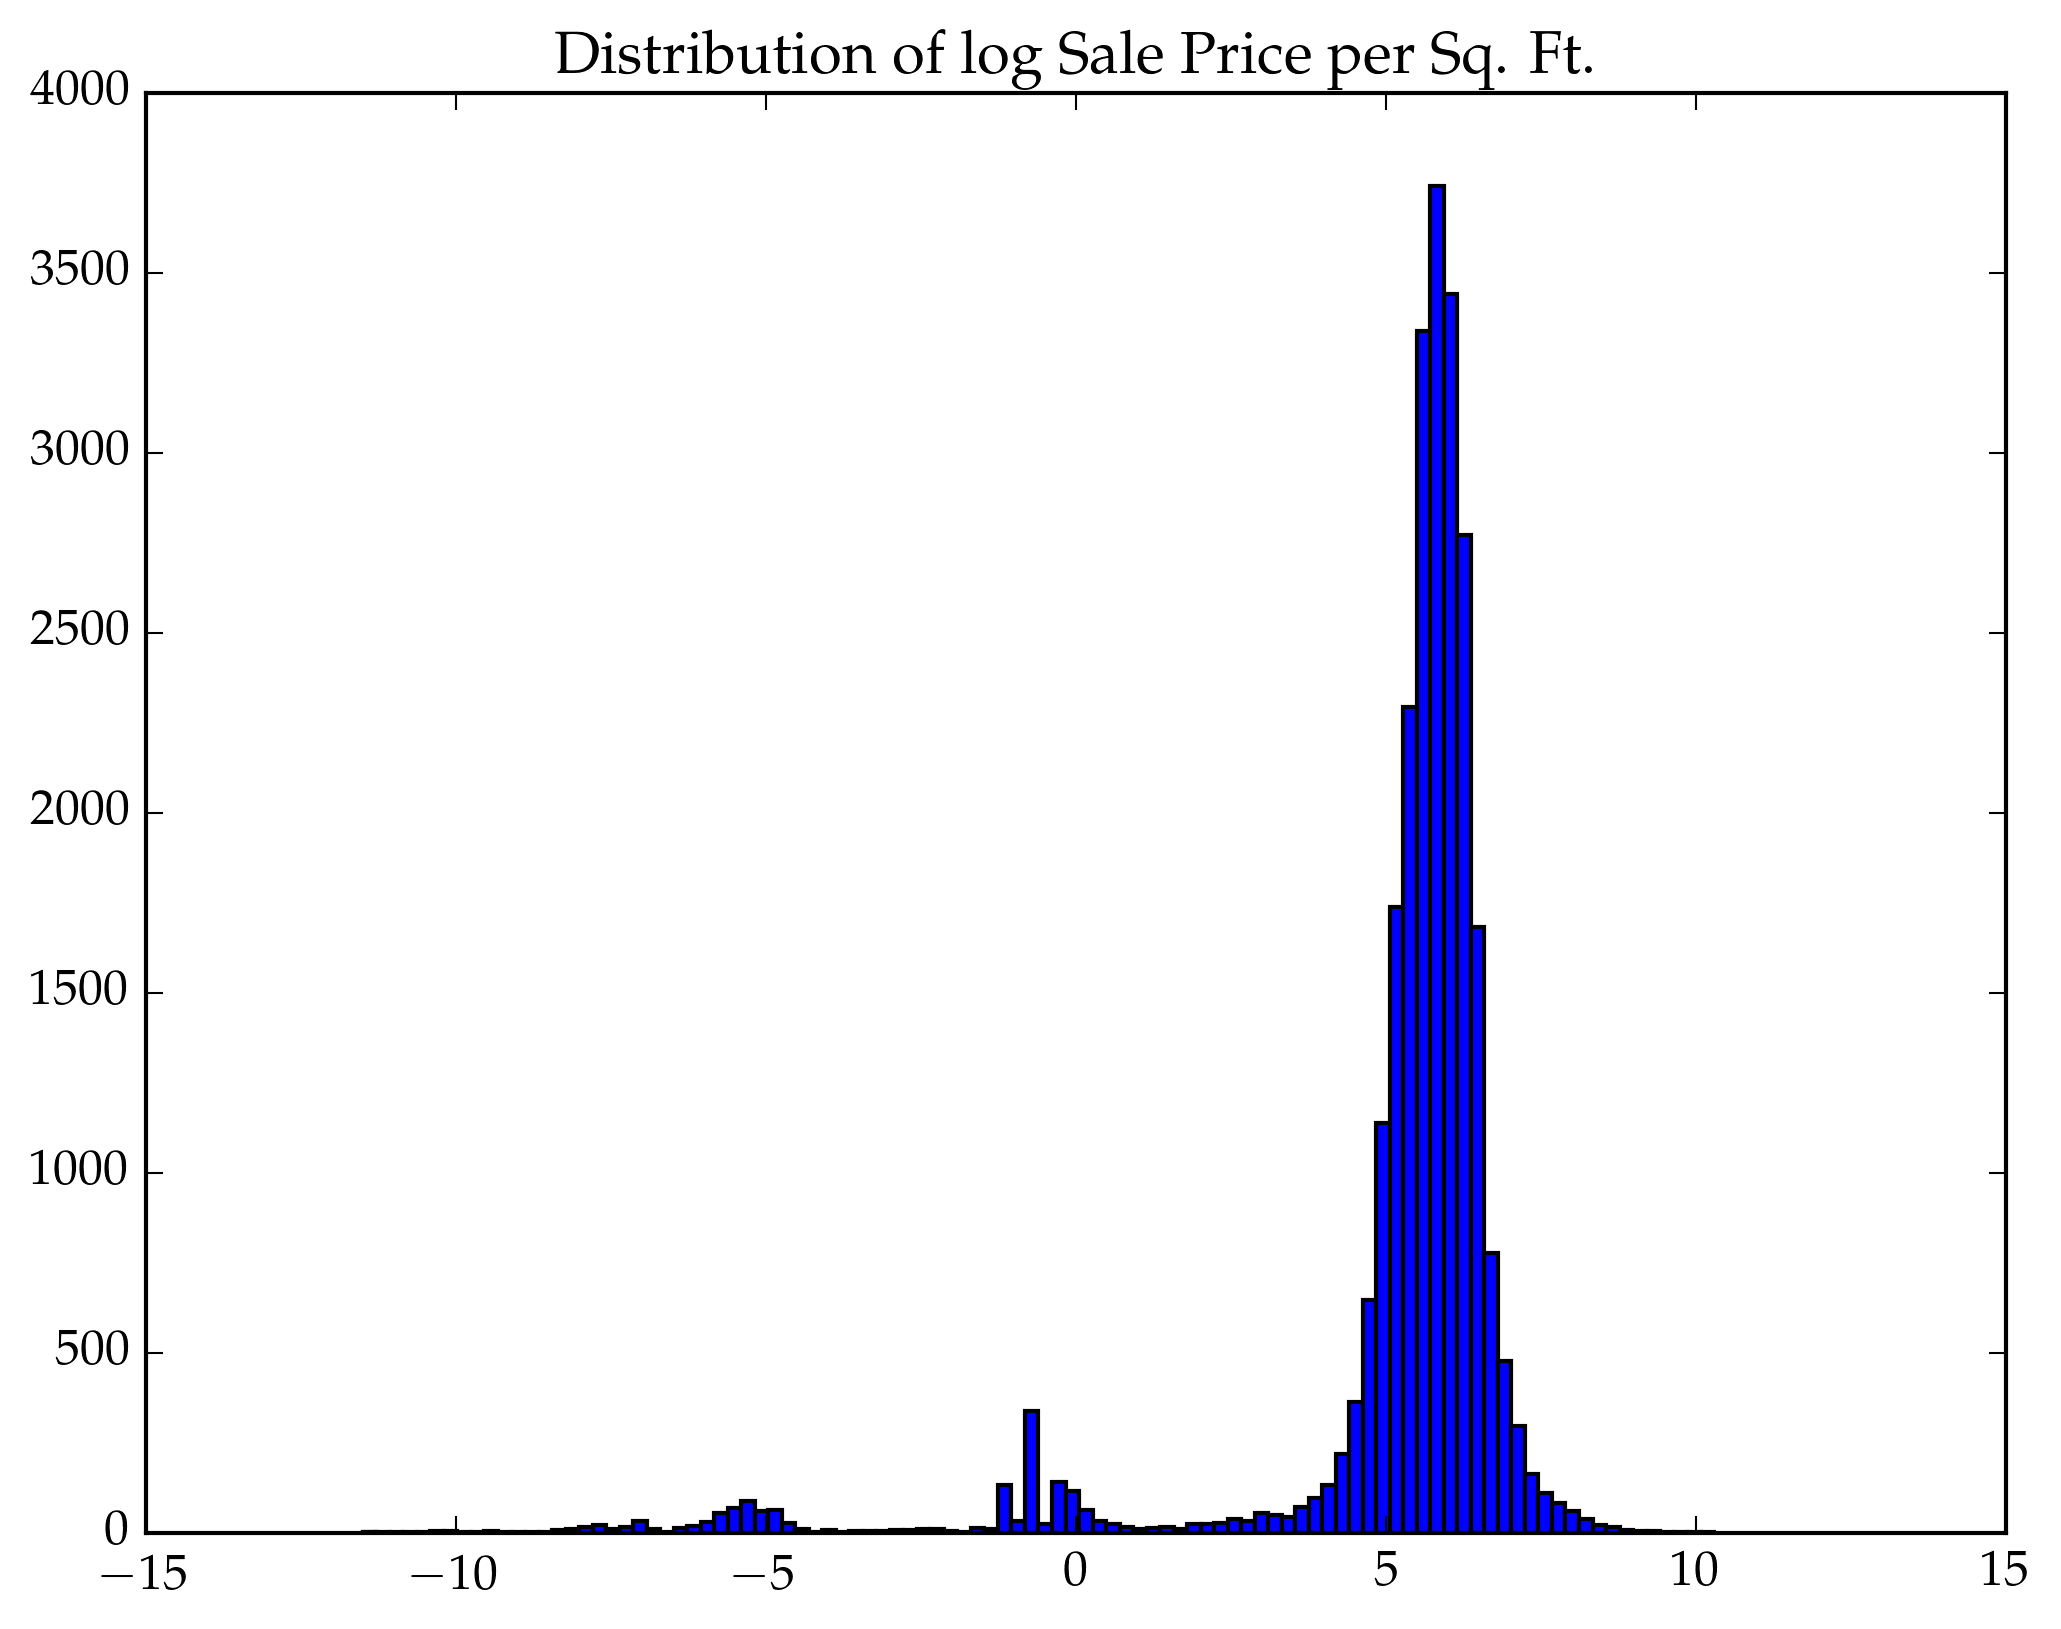

In [4]:
plt.plt[:hist](NYC_sales[believable,:logSalePricePerSQFT], bins=100)
plt.title("Distribution of log Sale Price per Sq. Ft.")
;

In [5]:
for i in 1:size(NYC_sales,1)
    if !believable[i]
        continue
    end
    if NYC_sales[i,:logSalePricePerSQFT] < 3.0
        # that's too cheap
        believable[i]=false
    end
    if NYC_sales[i,:logSalePricePerSQFT] > 8.0
        # that's too expensive
        believable[i]=false
    end
end
sum(believable)

23727

In [6]:
nobsv_ = sum(believable)
for_mm = copy(NYC_sales[believable,:])
# for_mm[:GROSS_SQUARE_FEET] =  for_mm[:GROSS_SQUARE_FEET] .- mean(for_mm[:GROSS_SQUARE_FEET])
# for_mm[:GROSS_SQUARE_FEET] = for_mm[:GROSS_SQUARE_FEET] ./ std(for_mm[:GROSS_SQUARE_FEET])
reordering = collect(1:nobsv_)
schdistrs = unique(for_mm[:,:SchDistr])
delete!
istart = 1
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
schdistr_indices = Dict{Int,Vector{Int}}()
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    schdistr_indices[name] = indices
end
;

In [7]:
Y_dict=Dict{Int, Vector{Float64}}()
X_dict=Dict{Int, Array{Float64,2}}()
for name in schdistrs
    Y_dict[name] = for_mm[schdistr_indices[name], :logSalePricePerSQFT]
    X_dict[name] = for_mm[schdistr_indices[name],[:X_PRJ, :Y_PRJ]]
end
sentinels_json=GeoJSON.parsefile("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{Int,Int},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

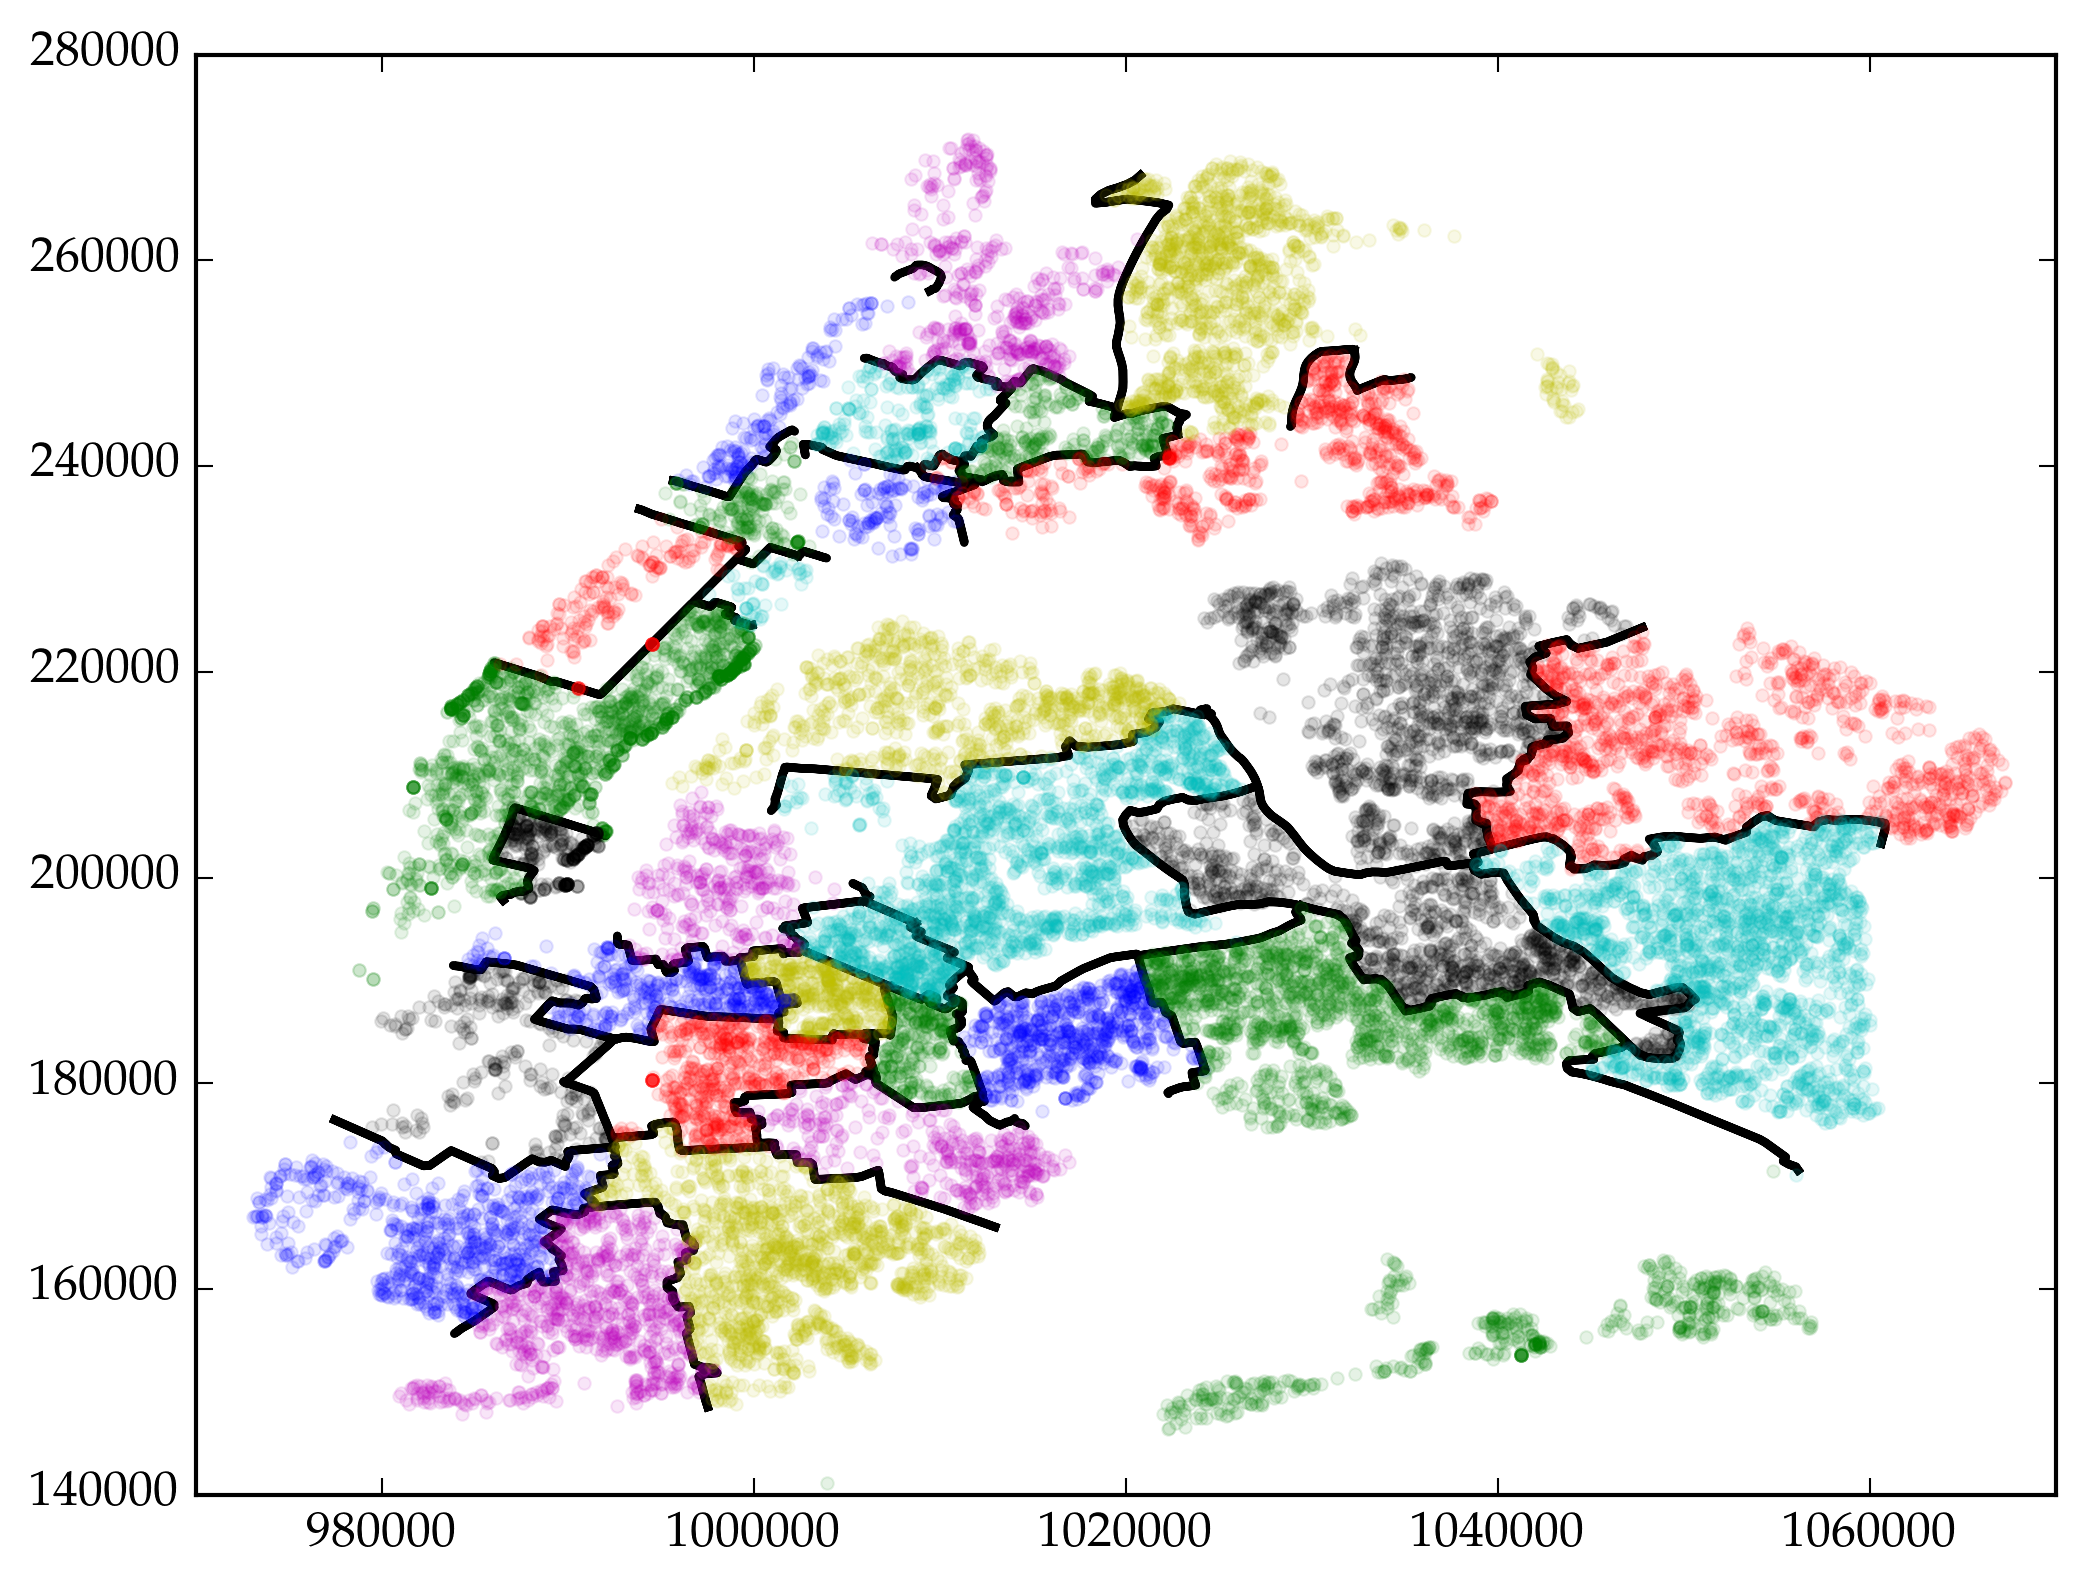

In [8]:
for (key,val) in sentinels
    X◫ = hcat(val.coordinates...)
    plt.plot(X◫[1,:], X◫[2,:], color="black", linewidth=2)
end
_xlim = plt.xlim()
_ylim = plt.ylim()
for name in schdistrs
    plt.plot(X_dict[name]'[1,:], X_dict[name]'[2,:], ".", alpha=0.1)
end
plt.xlim(_xlim)
plt.ylim(_ylim)
;

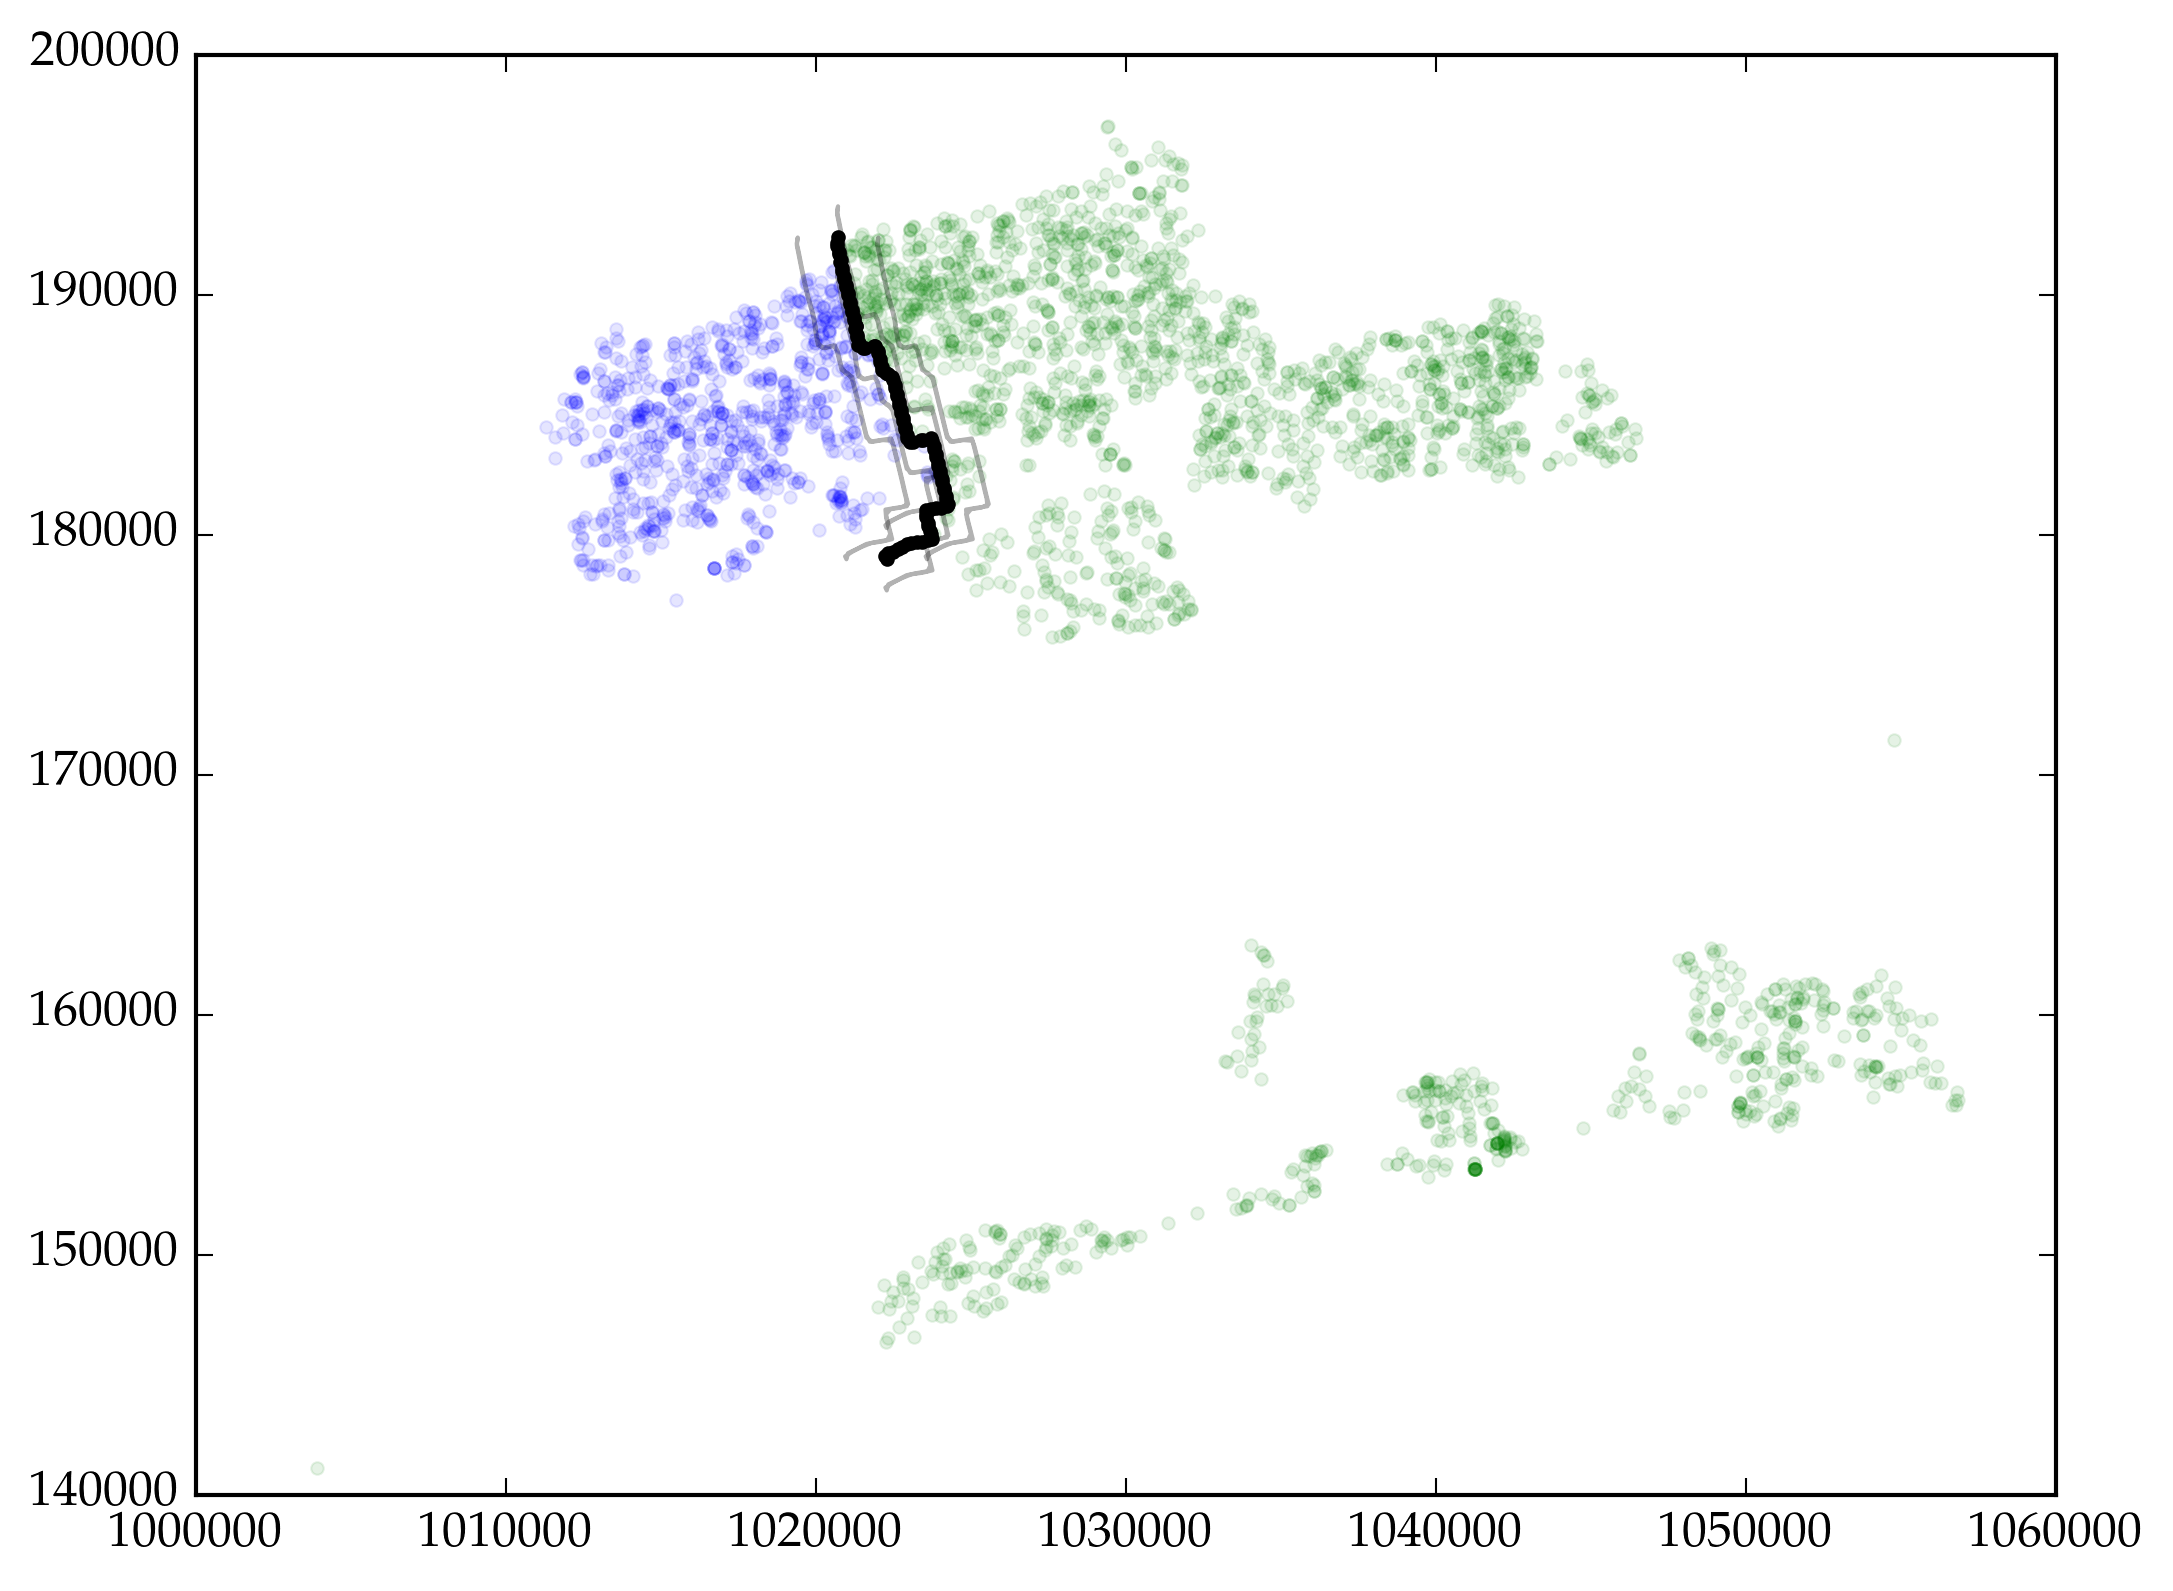

In [9]:
distrA = 19
distrB = 27
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
n◫ = size(X◫, 2)
for name in (distrA, distrB)
    plt.plot(X_dict[name]'[1,:], X_dict[name]'[2,:], ".", alpha=0.1)
end
_xlim = plt.xlim()
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
plt.plot(X◫[1,:], X◫[2,:], color="black", ".")
_L=1300
plt.plot(X◫[1,:].-_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:].+_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].-_L, color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].+_L, color="black", alpha=0.3)
# plt.xlim(780000, 810000)
# plt.ylim(450000,470000)
;

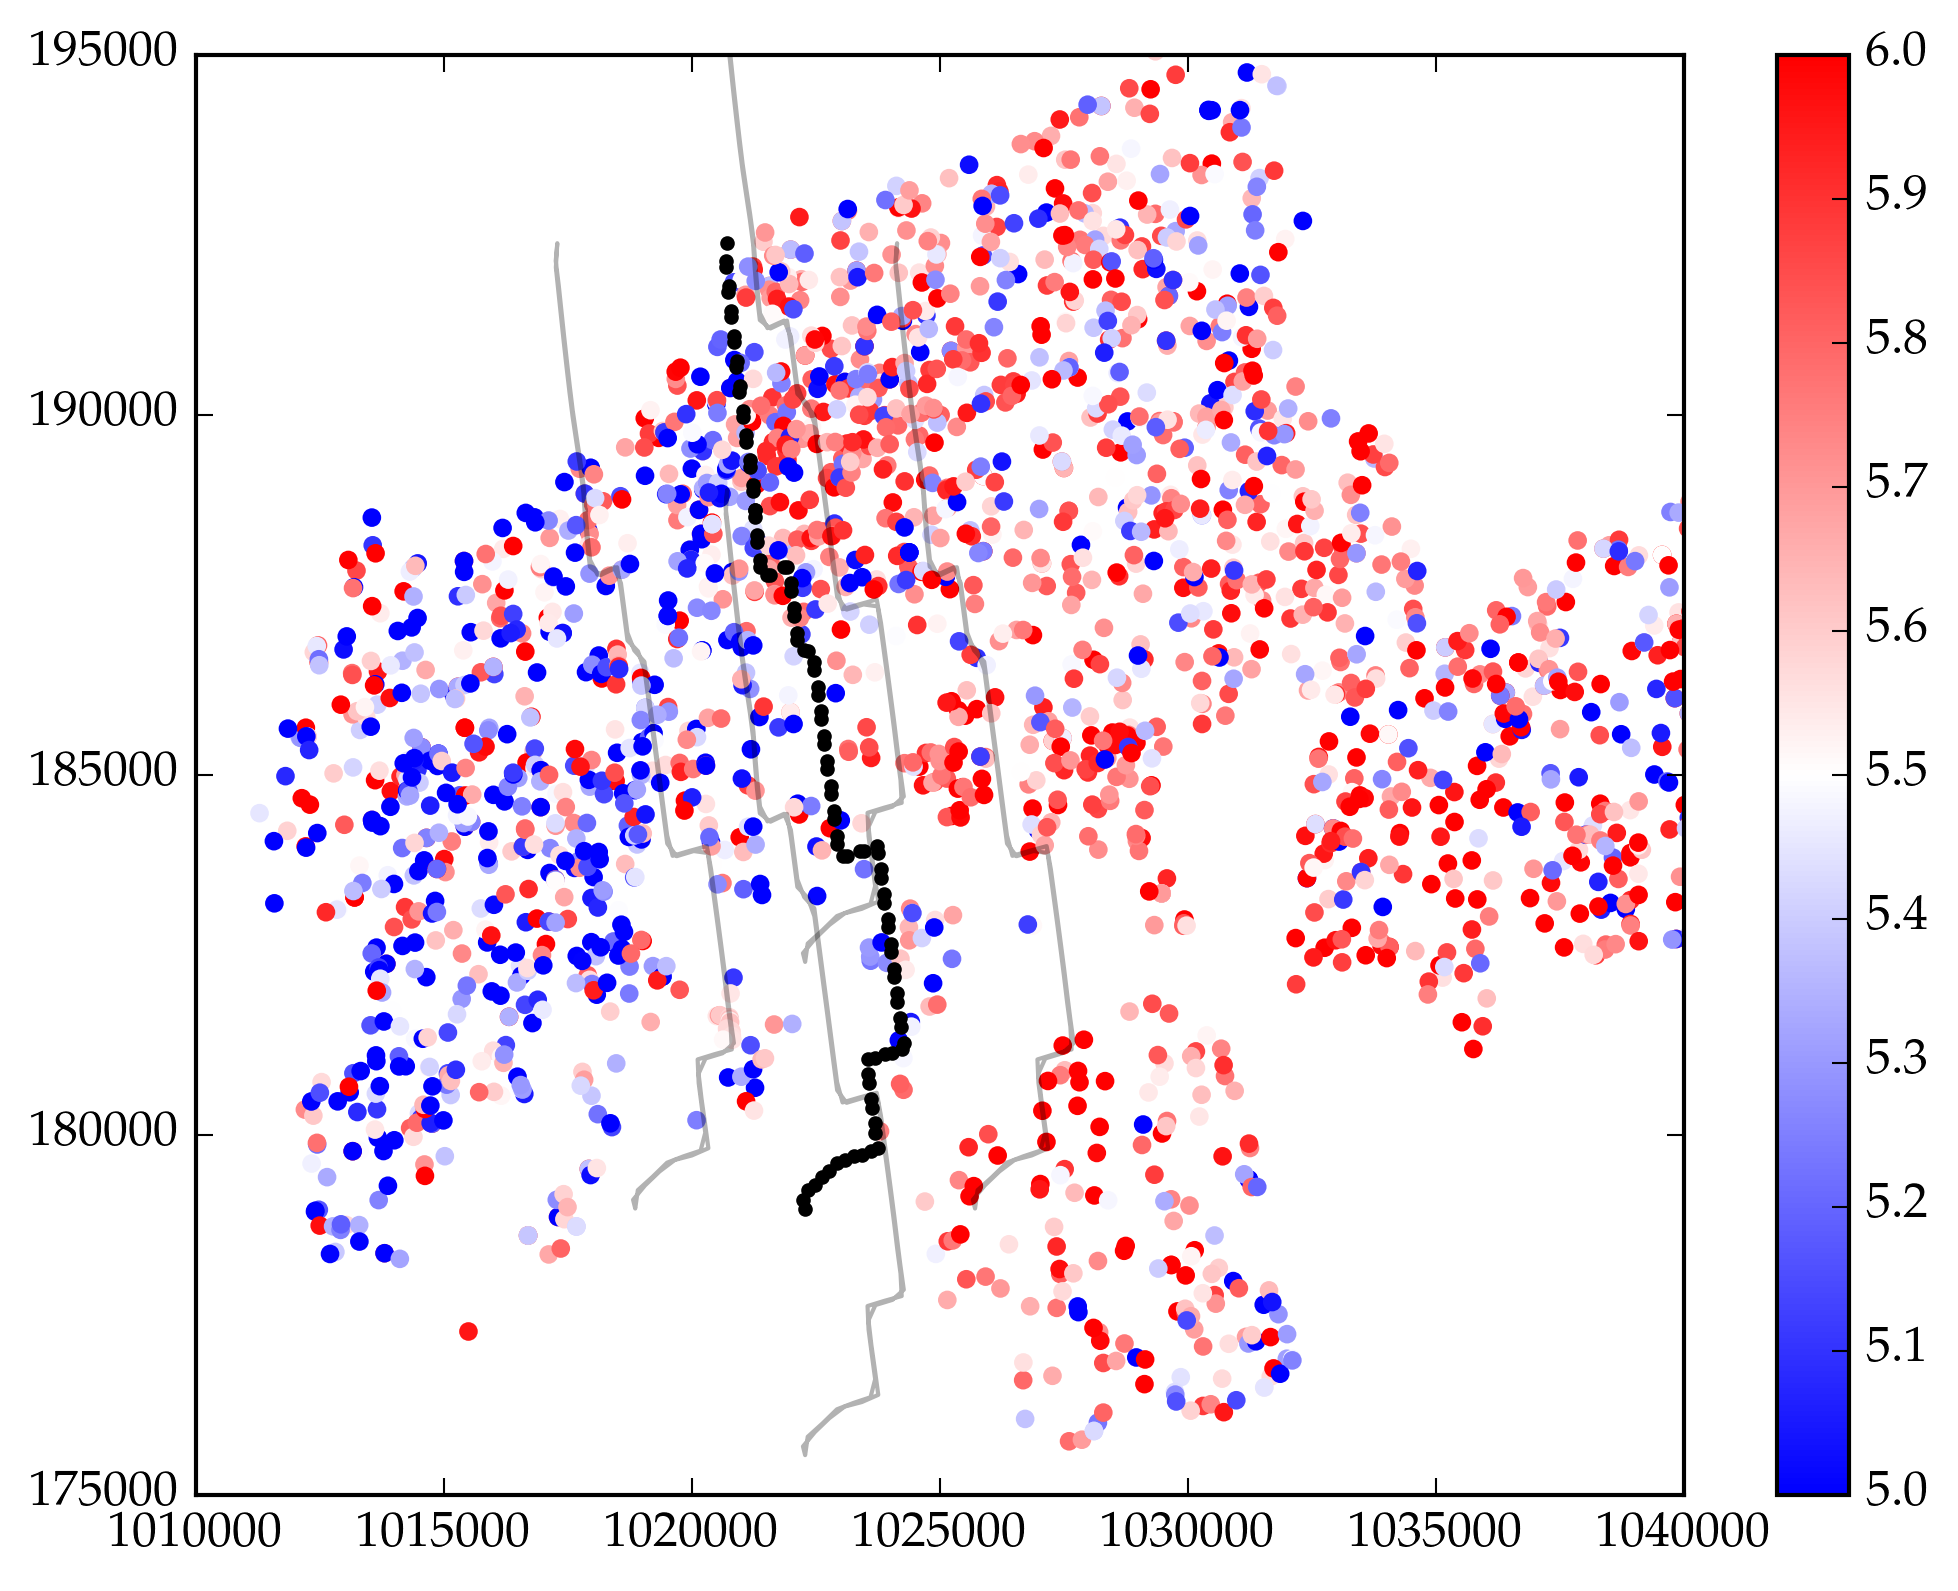

In [10]:
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
n◫ = size(X◫, 2)
for name in (distrA, distrB)
    plt.scatter(X_dict[name]'[1,:], X_dict[name]'[2,:],c=Y_dict[name], cmap="bwr", edgecolor="None", vmin=5, vmax=6)
end
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
plt.plot(X◫[1,:], X◫[2,:], color="black", ".")
_L=3425.2547
plt.plot(X◫[1,:].-_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:].+_L, X◫[2,:], color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].-_L, color="black", alpha=0.3)
plt.plot(X◫[1,:], X◫[2,:].+_L, color="black", alpha=0.3)
plt.xlim(1010000,1040000)
plt.ylim(175000,195000)
plt.colorbar()
;